In [13]:
# Let's try to use cuda if possible
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [14]:
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [15]:
import torch
import torch.nn as nn

lat_v_size = 64
img_size = 28 * 28

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(img_size, lat_v_size)
        
    def forward(self, x):
        x = self.l1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(lat_v_size, img_size)
        
    def forward(self, x):
        x = self.l1(x)
        return x

In [16]:
def test_model(encoder, decoder, loss_fn, data_loader):
    original_states = encoder.training, decoder.training
    encoder.eval(), decoder.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch, _ in data_loader:
            batch = batch.to(device).reshape((-1, 1, 28*28))
            lat_v = encoder(batch)
            out = decoder(lat_v)
            total_loss += loss_fn(out, batch).item()
    encoder.train(original_states[0])
    decoder.train(original_states[1])
    return total_loss / len(test_loader)

In [17]:
from time import time
import torch
from tqdm import tqdm

epochs = 40
patience = 3  # Define patience for early stopping
loss_fn = torch.nn.MSELoss().to(device)
batch_sizes = [8,16,32,64,128,256, 512, 1024, 2048]

train_loss_curves = []
test_loss_curves = []
training_times = []

for bs in batch_sizes:
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs)
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]
    opt = torch.optim.Adam(params_to_optimize, lr=1e-3)
    best_test_loss = float('inf')
    patience_counter = 0
    test_losses = [test_model(encoder, decoder, loss_fn, test_loader)]
    train_losses = []
    log_interv = 100
    encoder.train()
    decoder.train()
    start_t = time()
    test_time = 0.0 # Keep track of how much time we spend on testing since this will be subtracted from train time
    for epoch in range(epochs):
        if patience_counter > patience:  # Check if patience exceeded
            print("Early stopping triggered")
            break
        print(f"Batch size: {bs} epoch: {epoch}")
        for i, (batch, _) in enumerate(tqdm(train_loader)):
            batch = batch.to(device).reshape((-1, 1, 28*28))
            lat_v = encoder(batch)
            out = decoder(lat_v)
            loss = loss_fn(out, batch)
            train_losses.append(loss.cpu().detach().numpy())
            opt.zero_grad()
            loss.backward()
            opt.step()
            if i % log_interv == 0:
                test_time_start = time()
                current_test_loss = test_model(encoder, decoder, loss_fn, test_loader)
                test_losses.append(current_test_loss)
                # Early stopping check
                if current_test_loss < best_test_loss:
                    best_test_loss = current_test_loss
                    patience_counter = 0  # Reset patience counter
                else:
                    patience_counter += 1  # Increment patience counter
                test_time += time() - test_time_start
    training_times.append(time()-start_t-test_time)
    test_losses.append(test_model(encoder, decoder, loss_fn, test_loader))
    test_loss_curves.append(test_losses)

Batch size: 8 epoch: 0


100%|██████████| 7500/7500 [04:25<00:00, 28.26it/s]


Early stopping triggered
Batch size: 16 epoch: 0


100%|██████████| 3750/3750 [02:11<00:00, 28.56it/s]


Early stopping triggered
Batch size: 32 epoch: 0


100%|██████████| 1875/1875 [01:03<00:00, 29.35it/s]


Batch size: 32 epoch: 1


100%|██████████| 1875/1875 [01:00<00:00, 31.07it/s]


Batch size: 32 epoch: 2


100%|██████████| 1875/1875 [01:01<00:00, 30.29it/s]


Early stopping triggered
Batch size: 64 epoch: 0


100%|██████████| 938/938 [00:37<00:00, 24.90it/s]


Batch size: 64 epoch: 1


100%|██████████| 938/938 [00:29<00:00, 32.26it/s]


Batch size: 64 epoch: 2


100%|██████████| 938/938 [00:31<00:00, 29.48it/s]


Batch size: 64 epoch: 3


100%|██████████| 938/938 [00:30<00:00, 30.35it/s]


Batch size: 64 epoch: 4


100%|██████████| 938/938 [00:33<00:00, 28.07it/s]


Batch size: 64 epoch: 5


100%|██████████| 938/938 [00:29<00:00, 31.96it/s]


Batch size: 64 epoch: 6


100%|██████████| 938/938 [00:34<00:00, 27.36it/s]


Batch size: 64 epoch: 7


100%|██████████| 938/938 [00:29<00:00, 32.12it/s]


Batch size: 64 epoch: 8


100%|██████████| 938/938 [00:30<00:00, 30.96it/s]


Early stopping triggered
Batch size: 128 epoch: 0


100%|██████████| 469/469 [00:18<00:00, 25.30it/s]


Batch size: 128 epoch: 1


100%|██████████| 469/469 [00:19<00:00, 23.55it/s]


Batch size: 128 epoch: 2


100%|██████████| 469/469 [00:18<00:00, 25.15it/s]


Batch size: 128 epoch: 3


100%|██████████| 469/469 [00:19<00:00, 24.55it/s]


Batch size: 128 epoch: 4


100%|██████████| 469/469 [00:19<00:00, 24.04it/s]


Batch size: 128 epoch: 5


100%|██████████| 469/469 [00:19<00:00, 24.19it/s]


Batch size: 128 epoch: 6


100%|██████████| 469/469 [00:18<00:00, 25.27it/s]


Batch size: 128 epoch: 7


100%|██████████| 469/469 [00:18<00:00, 24.79it/s]


Batch size: 128 epoch: 8


100%|██████████| 469/469 [00:20<00:00, 22.75it/s]


Early stopping triggered
Batch size: 256 epoch: 0


100%|██████████| 235/235 [00:15<00:00, 15.59it/s]


Batch size: 256 epoch: 1


100%|██████████| 235/235 [00:14<00:00, 16.02it/s]


Batch size: 256 epoch: 2


100%|██████████| 235/235 [00:14<00:00, 15.92it/s]


Batch size: 256 epoch: 3


100%|██████████| 235/235 [00:15<00:00, 15.04it/s]


Batch size: 256 epoch: 4


100%|██████████| 235/235 [00:16<00:00, 14.08it/s]


Batch size: 256 epoch: 5


100%|██████████| 235/235 [00:15<00:00, 14.69it/s]


Batch size: 256 epoch: 6


100%|██████████| 235/235 [00:14<00:00, 15.85it/s]


Batch size: 256 epoch: 7


100%|██████████| 235/235 [00:14<00:00, 16.76it/s]


Batch size: 256 epoch: 8


100%|██████████| 235/235 [00:14<00:00, 16.08it/s]


Batch size: 256 epoch: 9


100%|██████████| 235/235 [00:14<00:00, 16.48it/s]


Batch size: 256 epoch: 10


100%|██████████| 235/235 [00:13<00:00, 18.00it/s]


Batch size: 256 epoch: 11


100%|██████████| 235/235 [00:13<00:00, 16.80it/s]


Batch size: 256 epoch: 12


100%|██████████| 235/235 [00:15<00:00, 15.35it/s]


Batch size: 256 epoch: 13


100%|██████████| 235/235 [00:14<00:00, 16.18it/s]


Batch size: 256 epoch: 14


100%|██████████| 235/235 [00:22<00:00, 10.23it/s]


Batch size: 256 epoch: 15


100%|██████████| 235/235 [00:37<00:00,  6.22it/s]


Batch size: 256 epoch: 16


100%|██████████| 235/235 [00:52<00:00,  4.46it/s]


Batch size: 256 epoch: 17


100%|██████████| 235/235 [00:20<00:00, 11.21it/s]


Batch size: 256 epoch: 18


100%|██████████| 235/235 [00:17<00:00, 13.43it/s]


Batch size: 256 epoch: 19


100%|██████████| 235/235 [00:14<00:00, 15.93it/s]


Batch size: 256 epoch: 20


100%|██████████| 235/235 [00:18<00:00, 12.44it/s]


Batch size: 256 epoch: 21


100%|██████████| 235/235 [00:34<00:00,  6.87it/s]


Batch size: 256 epoch: 22


100%|██████████| 235/235 [00:20<00:00, 11.31it/s]


Batch size: 256 epoch: 23


100%|██████████| 235/235 [00:16<00:00, 14.02it/s]


Batch size: 256 epoch: 24


100%|██████████| 235/235 [00:17<00:00, 13.22it/s]


Batch size: 256 epoch: 25


100%|██████████| 235/235 [00:15<00:00, 15.53it/s]


Batch size: 256 epoch: 26


100%|██████████| 235/235 [00:43<00:00,  5.35it/s]


Batch size: 256 epoch: 27


100%|██████████| 235/235 [00:46<00:00,  5.02it/s]


Batch size: 256 epoch: 28


100%|██████████| 235/235 [00:39<00:00,  6.02it/s]


Batch size: 256 epoch: 29


100%|██████████| 235/235 [00:34<00:00,  6.87it/s]


Batch size: 256 epoch: 30


100%|██████████| 235/235 [00:27<00:00,  8.63it/s]


Batch size: 256 epoch: 31


100%|██████████| 235/235 [00:55<00:00,  4.21it/s]


Batch size: 256 epoch: 32


100%|██████████| 235/235 [00:21<00:00, 10.75it/s]


Batch size: 256 epoch: 33


100%|██████████| 235/235 [00:52<00:00,  4.50it/s]


Batch size: 256 epoch: 34


100%|██████████| 235/235 [00:47<00:00,  4.98it/s]


Batch size: 256 epoch: 35


100%|██████████| 235/235 [01:09<00:00,  3.36it/s]


Batch size: 256 epoch: 36


100%|██████████| 235/235 [01:02<00:00,  3.76it/s]


Batch size: 256 epoch: 37


100%|██████████| 235/235 [00:17<00:00, 13.36it/s]


Batch size: 256 epoch: 38


100%|██████████| 235/235 [00:14<00:00, 16.02it/s]


Early stopping triggered
Batch size: 512 epoch: 0


100%|██████████| 118/118 [00:13<00:00,  9.01it/s]


Batch size: 512 epoch: 1


100%|██████████| 118/118 [00:12<00:00,  9.73it/s]


Batch size: 512 epoch: 2


100%|██████████| 118/118 [00:22<00:00,  5.33it/s]


Batch size: 512 epoch: 3


100%|██████████| 118/118 [00:31<00:00,  3.74it/s]


Batch size: 512 epoch: 4


100%|██████████| 118/118 [00:40<00:00,  2.93it/s]


Batch size: 512 epoch: 5


100%|██████████| 118/118 [00:49<00:00,  2.37it/s]


Batch size: 512 epoch: 6


100%|██████████| 118/118 [00:41<00:00,  2.85it/s]


Batch size: 512 epoch: 7


100%|██████████| 118/118 [00:18<00:00,  6.48it/s]


Batch size: 512 epoch: 8


100%|██████████| 118/118 [00:55<00:00,  2.13it/s]


Batch size: 512 epoch: 9


100%|██████████| 118/118 [00:27<00:00,  4.30it/s]


Batch size: 512 epoch: 10


100%|██████████| 118/118 [00:28<00:00,  4.16it/s]


Batch size: 512 epoch: 11


100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Batch size: 512 epoch: 12


100%|██████████| 118/118 [00:12<00:00,  9.48it/s]


Batch size: 512 epoch: 13


100%|██████████| 118/118 [00:11<00:00,  9.84it/s]


Batch size: 512 epoch: 14


100%|██████████| 118/118 [00:36<00:00,  3.26it/s]


Batch size: 512 epoch: 15


100%|██████████| 118/118 [00:43<00:00,  2.73it/s]


Batch size: 512 epoch: 16


100%|██████████| 118/118 [00:40<00:00,  2.93it/s]


Batch size: 512 epoch: 17


100%|██████████| 118/118 [00:17<00:00,  6.67it/s]


Batch size: 512 epoch: 18


100%|██████████| 118/118 [00:21<00:00,  5.50it/s]


Batch size: 512 epoch: 19


100%|██████████| 118/118 [00:50<00:00,  2.34it/s]


Batch size: 512 epoch: 20


100%|██████████| 118/118 [00:33<00:00,  3.53it/s]


Batch size: 512 epoch: 21


100%|██████████| 118/118 [00:18<00:00,  6.46it/s]


Batch size: 512 epoch: 22


100%|██████████| 118/118 [00:12<00:00,  9.34it/s]


Batch size: 512 epoch: 23


100%|██████████| 118/118 [00:12<00:00,  9.52it/s]


Batch size: 512 epoch: 24


100%|██████████| 118/118 [00:12<00:00,  9.26it/s]


Batch size: 512 epoch: 25


100%|██████████| 118/118 [00:31<00:00,  3.72it/s]


Batch size: 512 epoch: 26


100%|██████████| 118/118 [00:36<00:00,  3.27it/s]


Batch size: 512 epoch: 27


100%|██████████| 118/118 [00:12<00:00,  9.57it/s]


Batch size: 512 epoch: 28


100%|██████████| 118/118 [00:12<00:00,  9.50it/s]


Batch size: 512 epoch: 29


100%|██████████| 118/118 [00:12<00:00,  9.38it/s]


Batch size: 512 epoch: 30


100%|██████████| 118/118 [00:13<00:00,  8.74it/s]


Batch size: 512 epoch: 31


100%|██████████| 118/118 [00:13<00:00,  8.47it/s]


Batch size: 512 epoch: 32


100%|██████████| 118/118 [00:13<00:00,  8.99it/s]


Batch size: 512 epoch: 33


100%|██████████| 118/118 [00:14<00:00,  8.38it/s]


Early stopping triggered
Batch size: 1024 epoch: 0


100%|██████████| 59/59 [00:11<00:00,  5.26it/s]


Batch size: 1024 epoch: 1


100%|██████████| 59/59 [00:10<00:00,  5.38it/s]


Batch size: 1024 epoch: 2


100%|██████████| 59/59 [00:10<00:00,  5.57it/s]


Batch size: 1024 epoch: 3


100%|██████████| 59/59 [00:10<00:00,  5.48it/s]


Batch size: 1024 epoch: 4


100%|██████████| 59/59 [00:11<00:00,  5.07it/s]


Batch size: 1024 epoch: 5


100%|██████████| 59/59 [00:10<00:00,  5.67it/s]


Batch size: 1024 epoch: 6


100%|██████████| 59/59 [00:11<00:00,  5.24it/s]


Batch size: 1024 epoch: 7


100%|██████████| 59/59 [00:11<00:00,  5.17it/s]


Batch size: 1024 epoch: 8


100%|██████████| 59/59 [00:10<00:00,  5.43it/s]


Batch size: 1024 epoch: 9


100%|██████████| 59/59 [00:11<00:00,  5.06it/s]


Batch size: 1024 epoch: 10


100%|██████████| 59/59 [00:10<00:00,  5.62it/s]


Batch size: 1024 epoch: 11


100%|██████████| 59/59 [00:10<00:00,  5.60it/s]


Batch size: 1024 epoch: 12


100%|██████████| 59/59 [00:11<00:00,  5.18it/s]


Batch size: 1024 epoch: 13


100%|██████████| 59/59 [00:17<00:00,  3.36it/s]


Batch size: 1024 epoch: 14


100%|██████████| 59/59 [00:11<00:00,  5.04it/s]


Batch size: 1024 epoch: 15


100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


Batch size: 1024 epoch: 16


100%|██████████| 59/59 [00:11<00:00,  5.05it/s]


Batch size: 1024 epoch: 17


100%|██████████| 59/59 [00:12<00:00,  4.80it/s]


Batch size: 1024 epoch: 18


100%|██████████| 59/59 [00:15<00:00,  3.81it/s]


Batch size: 1024 epoch: 19


100%|██████████| 59/59 [00:10<00:00,  5.45it/s]


Batch size: 1024 epoch: 20


100%|██████████| 59/59 [00:10<00:00,  5.40it/s]


Batch size: 1024 epoch: 21


100%|██████████| 59/59 [00:11<00:00,  5.35it/s]


Batch size: 1024 epoch: 22


100%|██████████| 59/59 [00:12<00:00,  4.83it/s]


Batch size: 1024 epoch: 23


100%|██████████| 59/59 [00:11<00:00,  5.05it/s]


Batch size: 1024 epoch: 24


100%|██████████| 59/59 [00:10<00:00,  5.48it/s]


Batch size: 1024 epoch: 25


100%|██████████| 59/59 [00:10<00:00,  5.66it/s]


Batch size: 1024 epoch: 26


100%|██████████| 59/59 [00:10<00:00,  5.65it/s]


Batch size: 1024 epoch: 27


100%|██████████| 59/59 [00:10<00:00,  5.43it/s]


Batch size: 1024 epoch: 28


100%|██████████| 59/59 [00:10<00:00,  5.68it/s]


Batch size: 1024 epoch: 29


100%|██████████| 59/59 [00:12<00:00,  4.74it/s]


Batch size: 1024 epoch: 30


100%|██████████| 59/59 [00:10<00:00,  5.60it/s]


Batch size: 1024 epoch: 31


100%|██████████| 59/59 [00:11<00:00,  5.29it/s]


Batch size: 1024 epoch: 32


100%|██████████| 59/59 [00:11<00:00,  4.97it/s]


Batch size: 1024 epoch: 33


100%|██████████| 59/59 [00:11<00:00,  5.23it/s]


Batch size: 1024 epoch: 34


100%|██████████| 59/59 [00:10<00:00,  5.61it/s]


Batch size: 1024 epoch: 35


100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


Batch size: 1024 epoch: 36


100%|██████████| 59/59 [00:13<00:00,  4.50it/s]


Batch size: 1024 epoch: 37


100%|██████████| 59/59 [00:12<00:00,  4.56it/s]


Batch size: 1024 epoch: 38


100%|██████████| 59/59 [00:11<00:00,  4.96it/s]


Batch size: 1024 epoch: 39


100%|██████████| 59/59 [00:11<00:00,  5.32it/s]


Batch size: 2048 epoch: 0


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]


Batch size: 2048 epoch: 1


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Batch size: 2048 epoch: 2


100%|██████████| 30/30 [00:10<00:00,  2.73it/s]


Batch size: 2048 epoch: 3


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


Batch size: 2048 epoch: 4


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Batch size: 2048 epoch: 5


100%|██████████| 30/30 [00:10<00:00,  2.80it/s]


Batch size: 2048 epoch: 6


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


Batch size: 2048 epoch: 7


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


Batch size: 2048 epoch: 8


100%|██████████| 30/30 [00:13<00:00,  2.18it/s]


Batch size: 2048 epoch: 9


100%|██████████| 30/30 [00:10<00:00,  2.81it/s]


Batch size: 2048 epoch: 10


100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


Batch size: 2048 epoch: 11


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]


Batch size: 2048 epoch: 12


100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Batch size: 2048 epoch: 13


100%|██████████| 30/30 [00:18<00:00,  1.59it/s]


Batch size: 2048 epoch: 14


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Batch size: 2048 epoch: 15


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]


Batch size: 2048 epoch: 16


100%|██████████| 30/30 [00:13<00:00,  2.24it/s]


Batch size: 2048 epoch: 17


100%|██████████| 30/30 [00:12<00:00,  2.49it/s]


Batch size: 2048 epoch: 18


100%|██████████| 30/30 [00:15<00:00,  1.95it/s]


Batch size: 2048 epoch: 19


100%|██████████| 30/30 [00:11<00:00,  2.66it/s]


Batch size: 2048 epoch: 20


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


Batch size: 2048 epoch: 21


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


Batch size: 2048 epoch: 22


100%|██████████| 30/30 [00:13<00:00,  2.28it/s]


Batch size: 2048 epoch: 23


100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Batch size: 2048 epoch: 24


100%|██████████| 30/30 [00:10<00:00,  2.97it/s]


Batch size: 2048 epoch: 25


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]


Batch size: 2048 epoch: 26


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


Batch size: 2048 epoch: 27


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]


Batch size: 2048 epoch: 28


100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


Batch size: 2048 epoch: 29


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


Batch size: 2048 epoch: 30


100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Batch size: 2048 epoch: 31


100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


Batch size: 2048 epoch: 32


100%|██████████| 30/30 [00:17<00:00,  1.71it/s]


Batch size: 2048 epoch: 33


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Batch size: 2048 epoch: 34


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


Batch size: 2048 epoch: 35


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]


Batch size: 2048 epoch: 36


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


Batch size: 2048 epoch: 37


100%|██████████| 30/30 [00:13<00:00,  2.15it/s]


Batch size: 2048 epoch: 38


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Batch size: 2048 epoch: 39


100%|██████████| 30/30 [00:11<00:00,  2.51it/s]


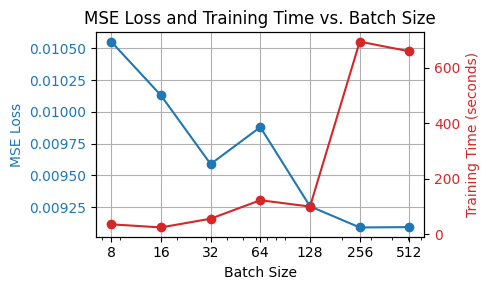

In [19]:
import matplotlib.pyplot as plt

r_mse        = [mse[-1] for mse in test_loss_curves]
fig, ax1 = plt.subplots(figsize=(5, 3))

# Plotting the MSE loss on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('MSE Loss', color=color)
ax1.plot(batch_sizes[:-2], r_mse[:-2], marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_xticks(batch_sizes)
ax1.set_xticklabels(batch_sizes)
ax1.grid(True)

# Creating the secondary y-axis for training time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (seconds)', color=color)
ax2.plot(batch_sizes[:-2], training_times[:-2], marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title and showing the plot
plt.title('MSE Loss and Training Time vs. Batch Size')
fig.tight_layout()
plt.show()